In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import shap

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from catboost import CatBoostClassifier

from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    confusion_matrix,
    classification_report
)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

PROJECT_ROOT = Path.cwd().parent
DATA_PATH = PROJECT_ROOT / "data"
RANDOM_STATE = 42

X_train = pd.read_feather(DATA_PATH / 'X_train.feather')
y_train = pd.read_feather(DATA_PATH / 'y_train.feather')['Class']
X_test = pd.read_feather(DATA_PATH / 'X_test.feather')
y_test = pd.read_feather(DATA_PATH / 'y_test.feather')['Class']

In [5]:
lr_final_model = LogisticRegression(
    random_state=RANDOM_STATE,
    class_weight='balanced',
    max_iter=1000
)
lr_final_model.fit(X_train, y_train)

if_final_model = IsolationForest(
    n_estimators=100,
    contamination=0.01,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
if_final_model.fit(X_train)

neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count

cb_final_model = CatBoostClassifier(
    iterations=2000,
    depth=6,
    learning_rate=0.05,
    random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight_value,
    verbose=0
)
cb_final_model.fit(X_train, y_train)

In [6]:
y_pred_proba_lr = lr_final_model.predict_proba(X_test)[:, 1]
y_pred_scores_if = -if_final_model.score_samples(X_test)
y_pred_proba_cb = cb_final_model.predict_proba(X_test)[:, 1]

Results:


,Model,PR-AUC,ROC-AUC
0,Logistic Regression,0.715586,0.971447
1,Isolation Forest,0.171441,0.952831
2,CatBoost,0.871922,0.973936


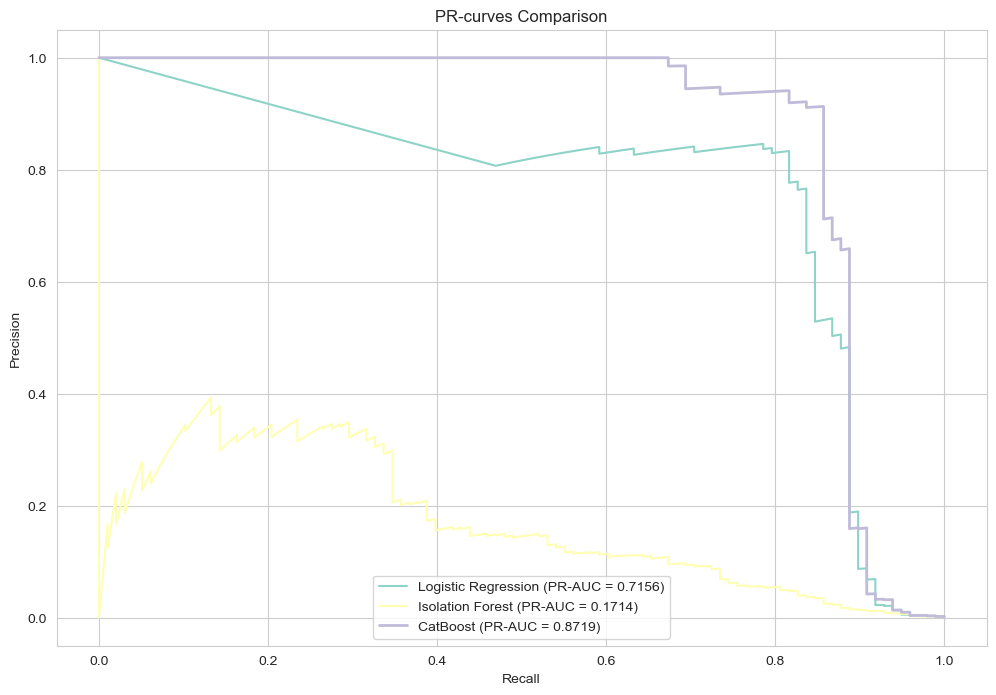

In [8]:
pr_auc_lr = average_precision_score(y_test, y_pred_proba_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

pr_auc_if = average_precision_score(y_test, y_pred_scores_if)
roc_auc_if = roc_auc_score(y_test, y_pred_scores_if)

pr_auc_cb = average_precision_score(y_test, y_pred_proba_cb)
roc_auc_cb = roc_auc_score(y_test, y_pred_proba_cb)

results = {
    "Model": ["Logistic Regression", "Isolation Forest", "CatBoost"],
    "PR-AUC": [pr_auc_lr, pr_auc_if, pr_auc_cb],
    "ROC-AUC": [roc_auc_lr, roc_auc_if, roc_auc_cb]
}
results_df = pd.DataFrame(results)
print("Results:")
display(results_df)


precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)
precision_if, recall_if, _ = precision_recall_curve(y_test, y_pred_scores_if)
precision_cb, recall_cb, _ = precision_recall_curve(y_test, y_pred_proba_cb)

plt.figure(figsize=(12, 8))
plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (PR-AUC = {pr_auc_lr:.4f})')
plt.plot(recall_if, precision_if, label=f'Isolation Forest (PR-AUC = {pr_auc_if:.4f})')
plt.plot(recall_cb, precision_cb, label=f'CatBoost (PR-AUC = {pr_auc_cb:.4f})', linewidth=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-curves Comparison')
plt.legend()
plt.grid(True)
plt.show()

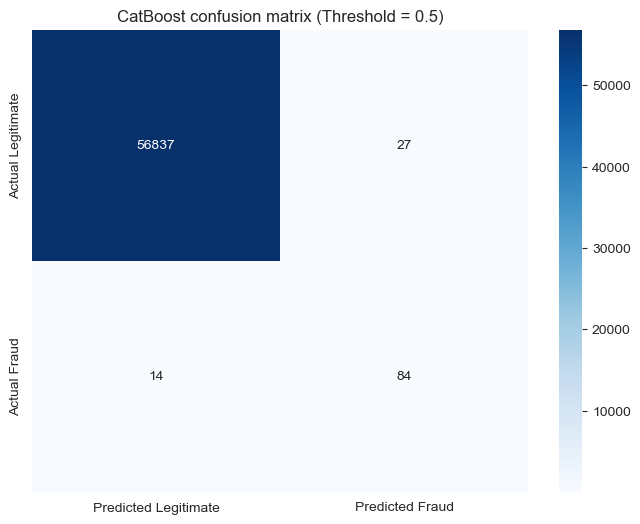


Classification Report:
                precision    recall  f1-score   support

Legitimate (0)       1.00      1.00      1.00     56864
     Fraud (1)       0.76      0.86      0.80        98

      accuracy                           1.00     56962
     macro avg       0.88      0.93      0.90     56962
  weighted avg       1.00      1.00      1.00     56962



In [10]:
THRESHOLD = 0.5
y_pred_cb_class = (y_pred_proba_cb >= THRESHOLD).astype(int)
cm = confusion_matrix(y_test, y_pred_cb_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Legitimate', 'Predicted Fraud'],
            yticklabels=['Actual Legitimate', 'Actual Fraud'])
plt.title(f'CatBoost confusion matrix (Threshold = {THRESHOLD})')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_cb_class, target_names=['Legitimate (0)', 'Fraud (1)']))


SHAP Summary Plot:


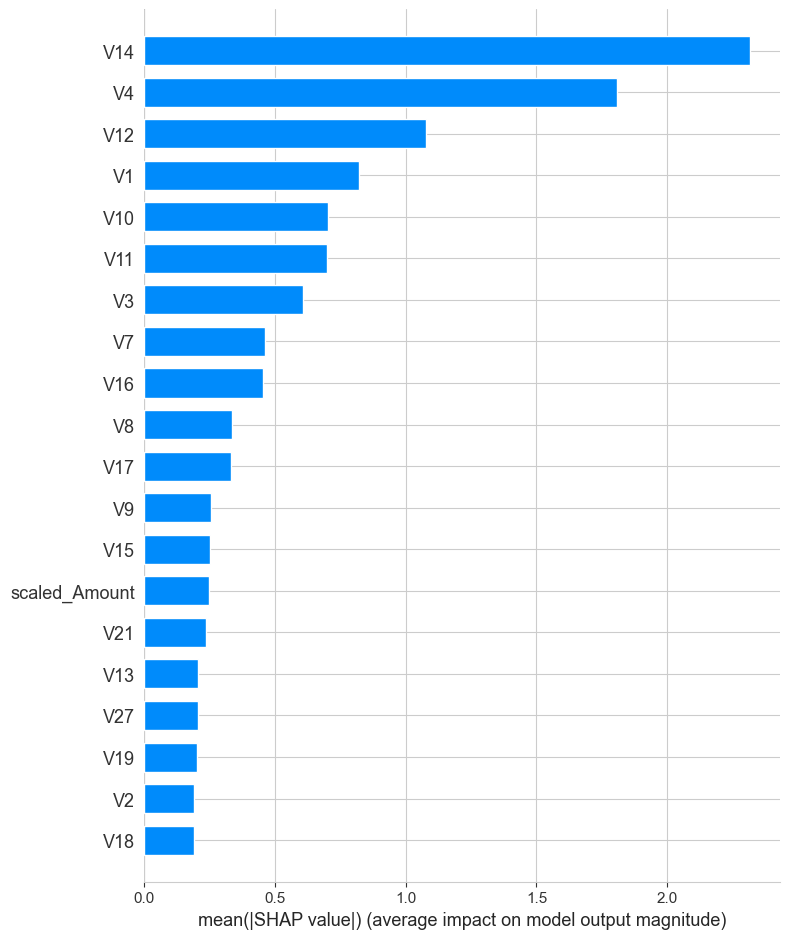

In [11]:
explainer = shap.TreeExplainer(cb_final_model)
shap_values = explainer.shap_values(X_test)

print("\nSHAP Summary Plot:")
shap.summary_plot(shap_values, X_test, plot_type="bar")


SHAP Summary Plot:


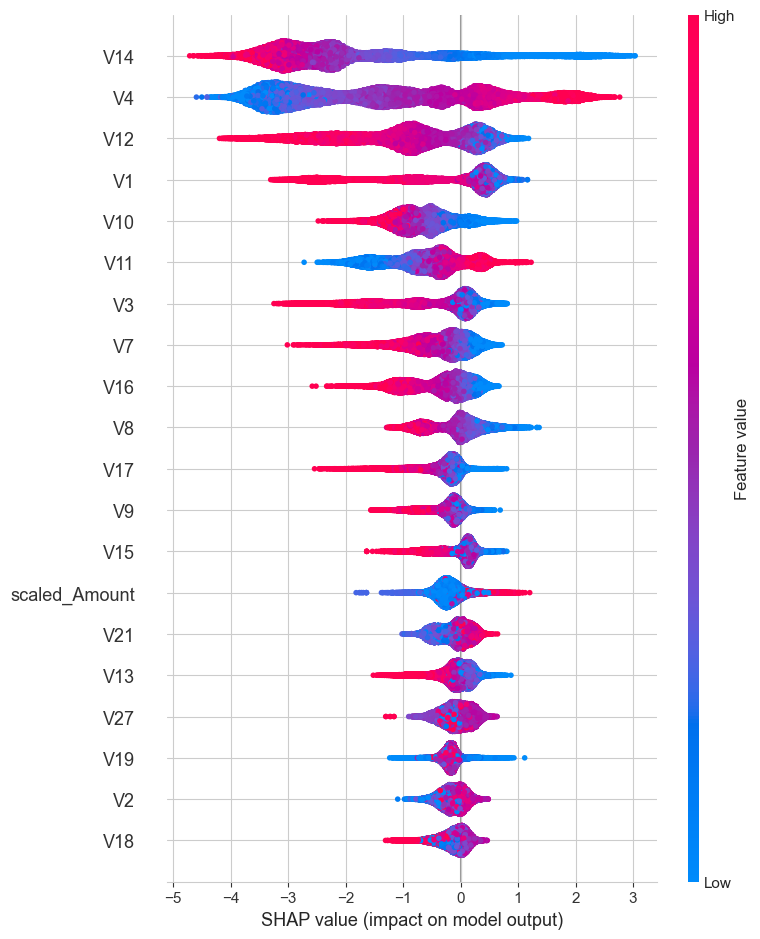


True Positive example (index 840)



False Negative example (index 17046)


In [18]:
print("\nSHAP Summary Plot:")
shap.summary_plot(shap_values, X_test)

shap.initjs()

tp_mask = (y_test == 1) & (y_pred_cb_class == 1)
tp_indices = np.where(tp_mask)[0]

if len(tp_indices) > 0:
    idx_to_explain = tp_indices[0]
    print(f"\nTrue Positive example (index {idx_to_explain})")
    display(shap.force_plot(explainer.expected_value, shap_values[idx_to_explain,:], X_test.iloc[idx_to_explain,:]))
else:
    print("\nNo True Positive examples.")

fn_mask = (y_test == 1) & (y_pred_cb_class == 0)
fn_indices = np.where(fn_mask)[0]

if len(fn_indices) > 0:
    idx_to_explain = fn_indices[0]
    print(f"\nFalse Negative example (index {idx_to_explain})")
    display(shap.force_plot(explainer.expected_value, shap_values[idx_to_explain,:], X_test.iloc[idx_to_explain,:]))
else:
    print("\nNo False Negative examples.")

In [19]:
y_true = y_test
y_pred_proba = y_pred_proba_cb

precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred_proba)

try:
    idx_recall_target = np.where(recall < 0.85)[0][0] - 1
    if idx_recall_target < 0:
         idx_recall_target = len(recall) - 2
except IndexError:
    idx_recall_target = len(recall) - 2


optimal_threshold = thresholds_pr[idx_recall_target]
recall_at_threshold = recall[idx_recall_target]
precision_at_threshold = precision[idx_recall_target]

print(f"Target Recall: >= 85%")
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"Recall: {recall_at_threshold:.2%}")
print(f"Precision: {precision_at_threshold:.2%}")

y_pred_class_optimal = (y_pred_proba >= optimal_threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred_class_optimal).ravel()
fpr = fp / (fp + tn)

print(f"\nFalse Positive: {fp}")
print(f"Total Legitimate: {tn + fp}")
print(f"False Positive Rate (FPR): {fpr:.4%}")

print(f"\nApplying an optimal classification threshold of {optimal_threshold:.4f} allows to identify {recall_at_threshold:.1%} of all fraudulent transactions (TP={tp}, FN={fn}), while maintaining a False Positive Rate of just {fpr:.3%} on legitimate operations (FP={fp}).")

Target Recall: >= 85%
Optimal threshold: 0.9413
Recall: 85.71%
Precision: 91.30%

False Positive: 8
Total Legitimate: 56864
False Positive Rate (FPR): 0.0141%

Applying an optimal classification threshold of 0.9413 allows to identify 85.7% of all fraudulent transactions (TP=84, FN=14), while maintaining a False Positive Rate of just 0.014% on legitimate operations (FP=8).
